# Required Libraries

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from pylab import rcParams
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from collections import defaultdict
from textwrap import wrap
from textblob import TextBlob
import pytorch_lightning as pl
import transformers
# from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
import joblib

# This Code will help to ignore version warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\MK
[nltk_data]     Jutt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data PreProcessing

In [3]:
df = pd.read_csv("amazon/Amazon_Smartphones_Reviews.csv")

In [4]:
df.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
5,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,I already had a phone with problems... I know ...,1.0
6,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,The charging port was loose. I got that solder...,0.0
7,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,"Phone looks good but wouldn't stay charged, ha...",0.0
8,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I originally was using the Samsung S2 Galaxy f...,0.0
9,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,3,It's battery life is great. It's very responsi...,0.0


In [5]:
df.shape

(413840, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [7]:
df.isnull().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

Product Name    0
Brand Name      0
Price           0
Rating          0
Reviews         0
Review Votes    0
dtype: int64

In [10]:
df.shape

(334335, 6)

In [11]:
df['Length'] = df['Reviews'].apply(len)

In [12]:
# Filter the Samsung Reviews from the dataset
samsung_reviews = df[df['Brand Name'] == 'Samsung']

# Print the filtered DataFrame
samsung_reviews



,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Length
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,374
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,214
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,12
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,76
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,223
...,...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0,30
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0,2
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0,43
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0,92


In [13]:
print(f"Review Votes : \n{df['Review Votes'].value_counts()}")

Review Votes : 
0.0      233064
1.0       47265
2.0       19652
3.0        9634
4.0        5727
          ...  
100.0         1
264.0         1
186.0         1
142.0         1
335.0         1
Name: Review Votes, Length: 234, dtype: int64


In [14]:
df['Brand Name'].unique()

array(['Samsung', 'Nokia', 'HTM', 'Jethro', 'e passion',
       'Cedar Tree Technologies', 'Indigi', 'Phone Baby', 'OtterBox',
       'Lenovo', 'Huawei', 'JUNING', 'Elephone', 'Plum', 'VKworld',
       'NOKIA', 'Ulefone', 'Jiuhe', 'inDigi', 'Acer', 'Aeku', 'Alcatel',
       'TCL Mobile', 'LG', 'amar', 'Amazon', 'Odysseus', 'Digital SNITCH',
       'star', 'Android', 'Yezz', 'Yezz Wireless Ltd.', 'Apple',
       'Apple Computer', 'Certified Refurbished',
       'Amazon.com, LLC *** KEEP PORules ACTIVE ***', 'apple',
       'ARGOM TECH', 'Asus', 'ASUS', 'ASUS Computers', 'asus',
       'BlackBerry', 'Motorola', 'Palm', 'Pantech', 'ZTE', 'ATT', 'Atoah',
       'BlackBerry Storm 9530 Smartphone Unlocked GSM Wireless Handheld Device w/Camera Bluetooth 3.25" Touchscreen LCD',
       'WorryFree Gadgets', 'worryfree', 'iDROID USA', 'Blackberry (Rim)',
       'Research In Motion', 'BLACKBERRY', 'Black Berry', 'Blackberry',
       'blackberry', 'RIM', 'Research in Motion', 'Blackberrry', 'Storm'

# Different Smartphones Reviews

In [15]:
# Filter the Samsung Reviews from the dataset
apple_reviews = df[df['Brand Name'] == 'Apple']

# Print the filtered DataFrame
apple_reviews


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Length
3081,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,5,Was a gift for my husband and he loves it. Rep...,5.0,260
3082,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,5,"Great price, extremely fast shipping works as ...",1.0,57
3083,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,4,Moving from Android to Apple...my kids have th...,1.0,337
3084,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,4,It is compatible with Verizon. Not pink but PE...,0.0,174
3085,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,5,I love this phone! Thank you so much.,1.0,37
...,...,...,...,...,...,...,...
410273,Virgin Mobile iPhone 5 Black,Apple,289.0,5,It came as a new item. No scratches. Works per...,1.0,51
410274,Virgin Mobile iPhone 5 Black,Apple,289.0,1,"In fact, this phone could not be activated by ...",1.0,306
410275,Virgin Mobile iPhone 5 Black,Apple,289.0,5,Nice phone.,0.0,11
410276,Virgin Mobile iPhone 5 Black,Apple,289.0,2,Why Is This iPhone Locked ?? And Only Came Wit...,4.0,152


In [16]:
# Filter the Samsung Reviews from the dataset
moto_reviews = df[df['Brand Name'] == 'Motorola']

# Print the filtered DataFrame
moto_reviews

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Length
83002,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,1,Not good,0.0,8
83003,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,1,junk did not work got a refund,0.0,30
83004,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,3,"I love the looks of it but,it has no S.D.slot....",0.0,127
83005,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,4,Got phone it had no scratches but can't find w...,0.0,191
83006,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,4,Works great,0.0,11
...,...,...,...,...,...,...,...
408245,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,Gets such good reception!,0.0,25
408246,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,This phone is the best. It cannot die. CAN NOT...,0.0,118
408247,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,These guys really know what the are doing.. Th...,0.0,136
408248,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,I bought this older phone for someone who like...,0.0,201


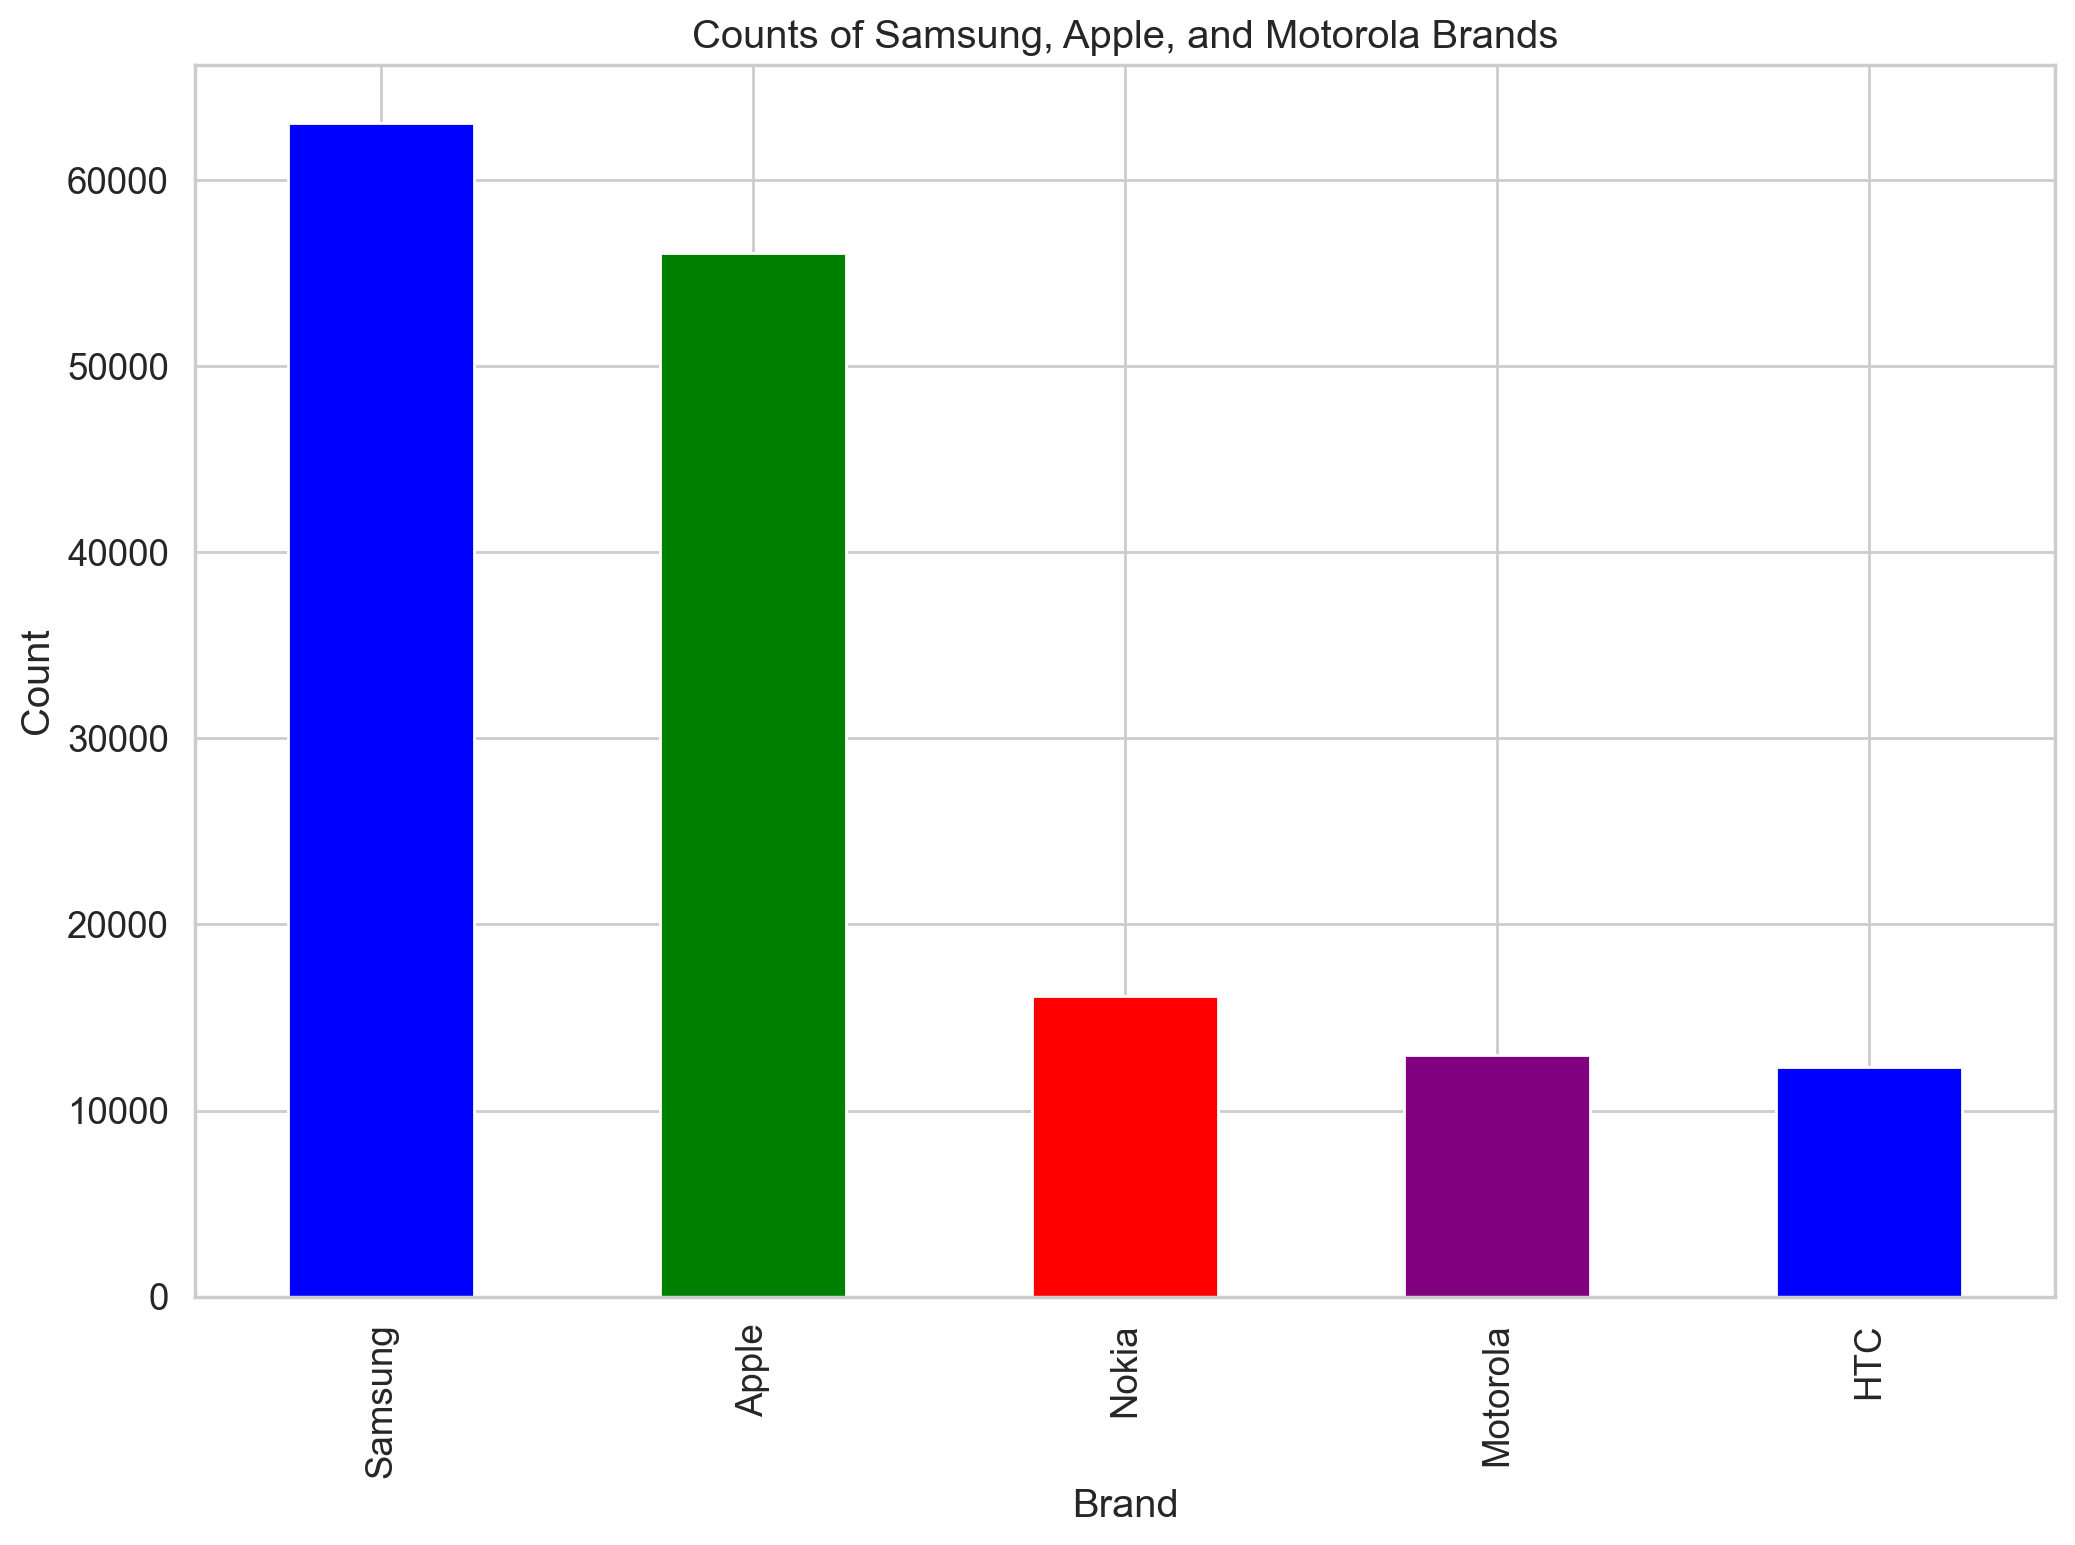

In [17]:
brand_column = 'Brand Name'

# Filter rows for Samsung, Apple, and Motorola brands
selected_brands = df[df[brand_column].isin(['Samsung', 'Apple', 'HTC', 'Motorola', 'Nokia'])]

# Create a bar plot
brand_counts = selected_brands[brand_column].value_counts()
brand_counts.plot(kind='bar', color=['blue', 'green', 'red', 'purple'])

# Customize the plot
plt.title('Counts of Samsung, Apple, and Motorola Brands')
plt.xlabel('Brand')
plt.ylabel('Count')

# Show the plot
plt.show()

In [18]:
print(f"Random Review : {df.iloc[400]['Reviews']}")
print(f"Length of  Review : {len(df.iloc[400]['Reviews'])}")
print(f"Length Column Value : {df.iloc[400]['Length']}")


Random Review : Not happy with this phone. Not able to get but 1 gh on this phone. I have been with T-Mobile for 5 years and been very satisfied with their service. Because this phone is foreign, neither TMobile or ATT were able to get a faster internet. It is very slow and very often says it cant open the page and says retry. Also, the screen of the phone began cracking within a week of having it. This phone is only good for making phone calls and texting.
Length of  Review : 445
Length Column Value : 445


In [19]:
print(f"Rating Value Count :\n {df['Rating'].value_counts()}")

Rating Value Count :
 5    180253
1     57535
4     50421
3     26058
2     20068
Name: Rating, dtype: int64


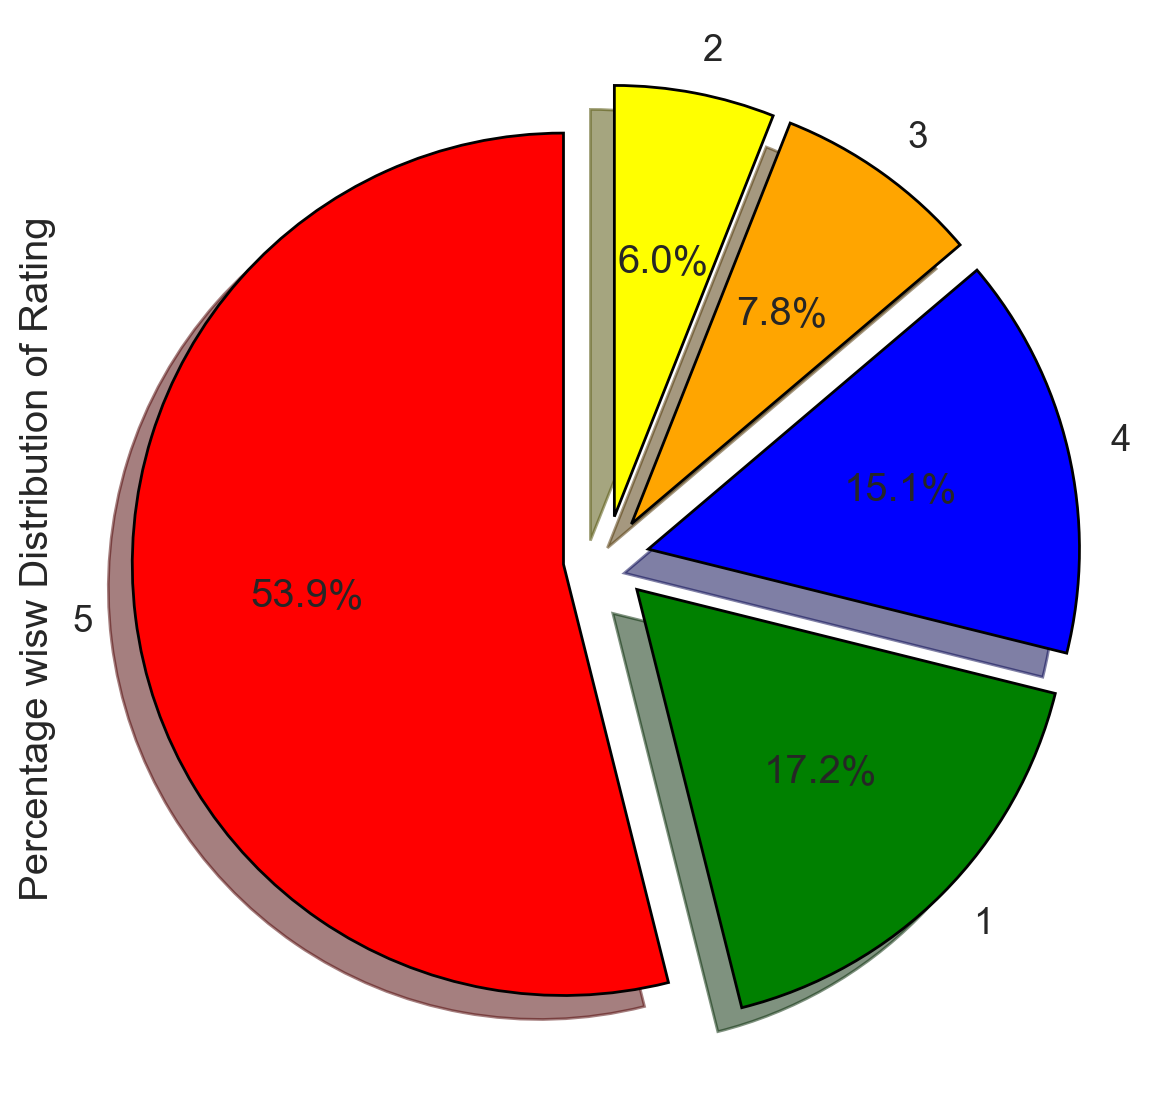

In [20]:
fig = plt.figure(figsize=(7, 7))

colors = ('red', 'green', 'blue', 'orange', 'yellow')

wp = {'linewidth':1, "edgecolor": "black"}

tags = df['Rating'].value_counts()/df.shape[0]

explode = (0.1, 0.1, 0.1, 0.1, 0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wisw Distribution of Rating')

from io import BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

# Data Cleaning and Processing Techniques

In [21]:
# Data Cleaning
df['Reviews'] = df['Reviews'].str.lower()
df['Reviews'] = df['Reviews'].replace('[^a-zA-Z0-9]', ' ', regex=True)

In [22]:
# Tokenization
df['Tokenized_Reviews'] = df['Reviews'].apply(word_tokenize)

In [23]:
# Stopword Removal
stop_words = set(stopwords.words('english'))
df['Filtered_Reviews'] = df['Tokenized_Reviews'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [24]:
# Stemming
ps = PorterStemmer()
df['Stemmed_Reviews'] = df['Filtered_Reviews'].apply(lambda x: [ps.stem(word) for word in x])

In [25]:
# Convert ratings to sentiment labels (e.g., positive, neutral, negative)
df['Sentiment'] = pd.cut(df['Rating'], bins=[0, 2.5, 3.5, 5], labels=['negative', 'neutral', 'positive'])


In [26]:
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Length,Tokenized_Reviews,Filtered_Reviews,Stemmed_Reviews,Sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,i feel so lucky to have found this used phone...,1.0,374,"[i, feel, so, lucky, to, have, found, this, us...","[feel, lucky, found, used, phone, us, used, ha...","[feel, lucki, found, use, phone, us, use, hard...",positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,nice phone nice up grade from my pantach revu...,0.0,214,"[nice, phone, nice, up, grade, from, my, panta...","[nice, phone, nice, grade, pantach, revue, cle...","[nice, phone, nice, grade, pantach, revu, clea...",positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,very pleased,0.0,12,"[very, pleased]",[pleased],[pleas],positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,it works good but it goes slow sometimes but i...,0.0,76,"[it, works, good, but, it, goes, slow, sometim...","[works, good, goes, slow, sometimes, good, pho...","[work, good, goe, slow, sometim, good, phone, ...",positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,great phone to replace my lost phone the only...,0.0,223,"[great, phone, to, replace, my, lost, phone, t...","[great, phone, replace, lost, phone, thing, vo...","[great, phone, replac, lost, phone, thing, vol...",positive
...,...,...,...,...,...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0,30,"[another, great, deal, great, price]","[another, great, deal, great, price]","[anoth, great, deal, great, price]",positive
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,ok,0.0,2,[ok],[ok],[ok],neutral
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,passes every drop test onto porcelain tile,0.0,43,"[passes, every, drop, test, onto, porcelain, t...","[passes, every, drop, test, onto, porcelain, t...","[pass, everi, drop, test, onto, porcelain, tile]",positive
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,i returned it because it did not meet my needs...,0.0,92,"[i, returned, it, because, it, did, not, meet,...","[returned, meet, needs, seemed, good, selectio...","[return, meet, need, seem, good, select, other]",neutral


# Feature Extraction

In [27]:
# Feature Extraction - TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Stemmed_Reviews'].apply(lambda x: ' '.join(x)))


# Multinomial Naive Bayes Model

In [28]:
# Sentiment Analysis Model - Multinomial Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Rating'], test_size=0.2, random_state=42)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

In [29]:
# Model Evaluation - Multinomial Naive Bayes
print("Multinomial Naive Bayes:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:\n", classification_report(y_test, nb_predictions))

Multinomial Naive Bayes:
Accuracy: 0.6769108827971945
Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.76      0.71     11570
           2       0.65      0.06      0.10      4039
           3       0.49      0.10      0.16      5228
           4       0.40      0.15      0.22     10025
           5       0.71      0.95      0.81     36005

    accuracy                           0.68     66867
   macro avg       0.58      0.40      0.40     66867
weighted avg       0.63      0.68      0.61     66867



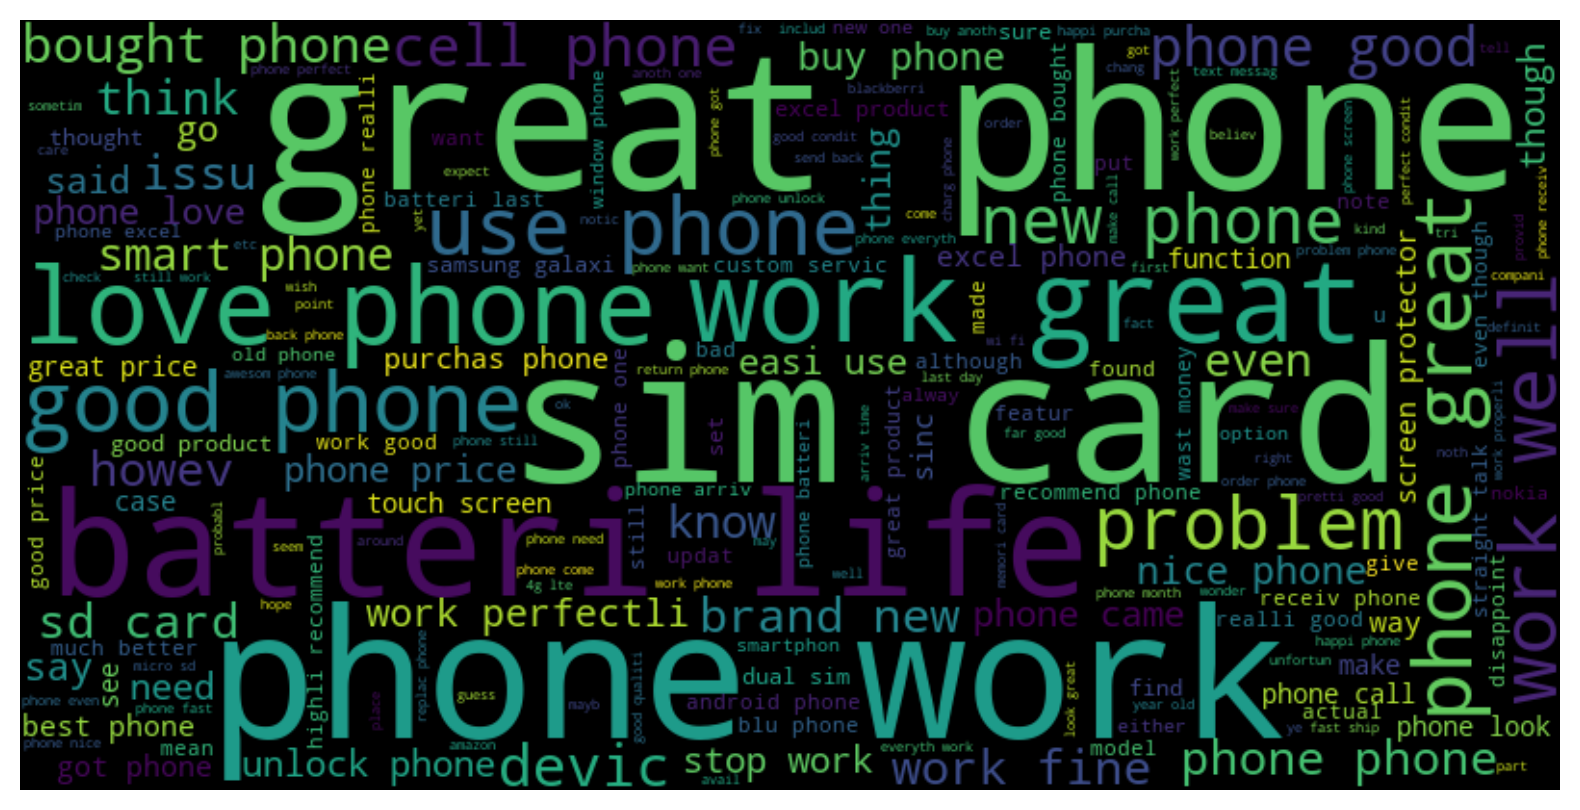

In [30]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100).generate(' '.join(df['Stemmed_Reviews'].apply(lambda x: ' '.join(x))))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

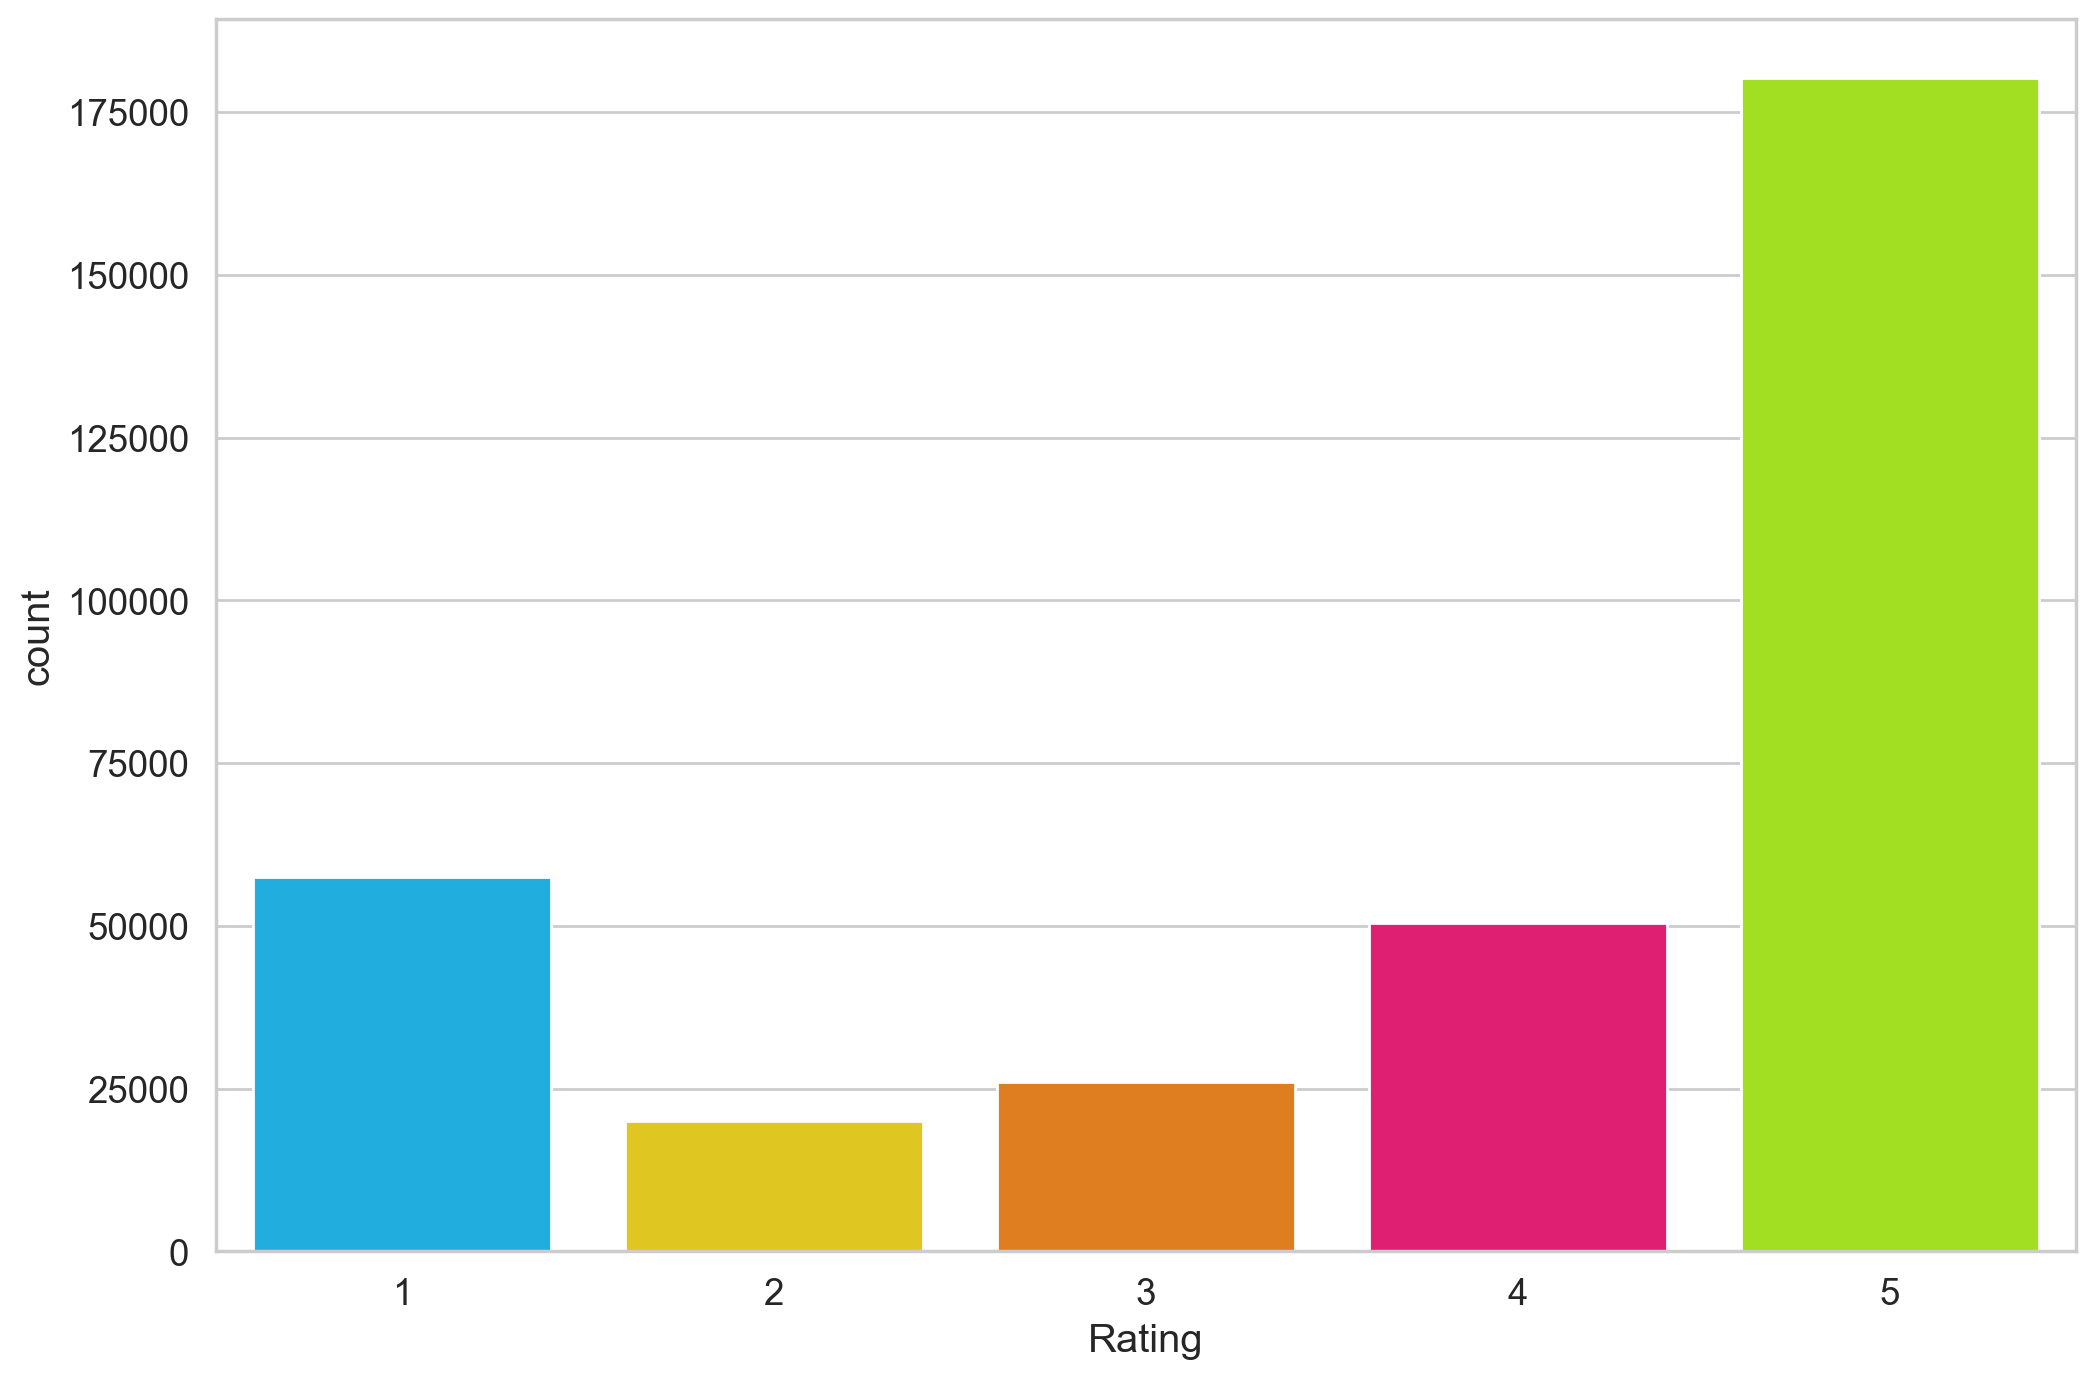

In [31]:
# Let's have a look at the class balance.
sns.countplot(df.Rating)
plt.xlabel('Rating');

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

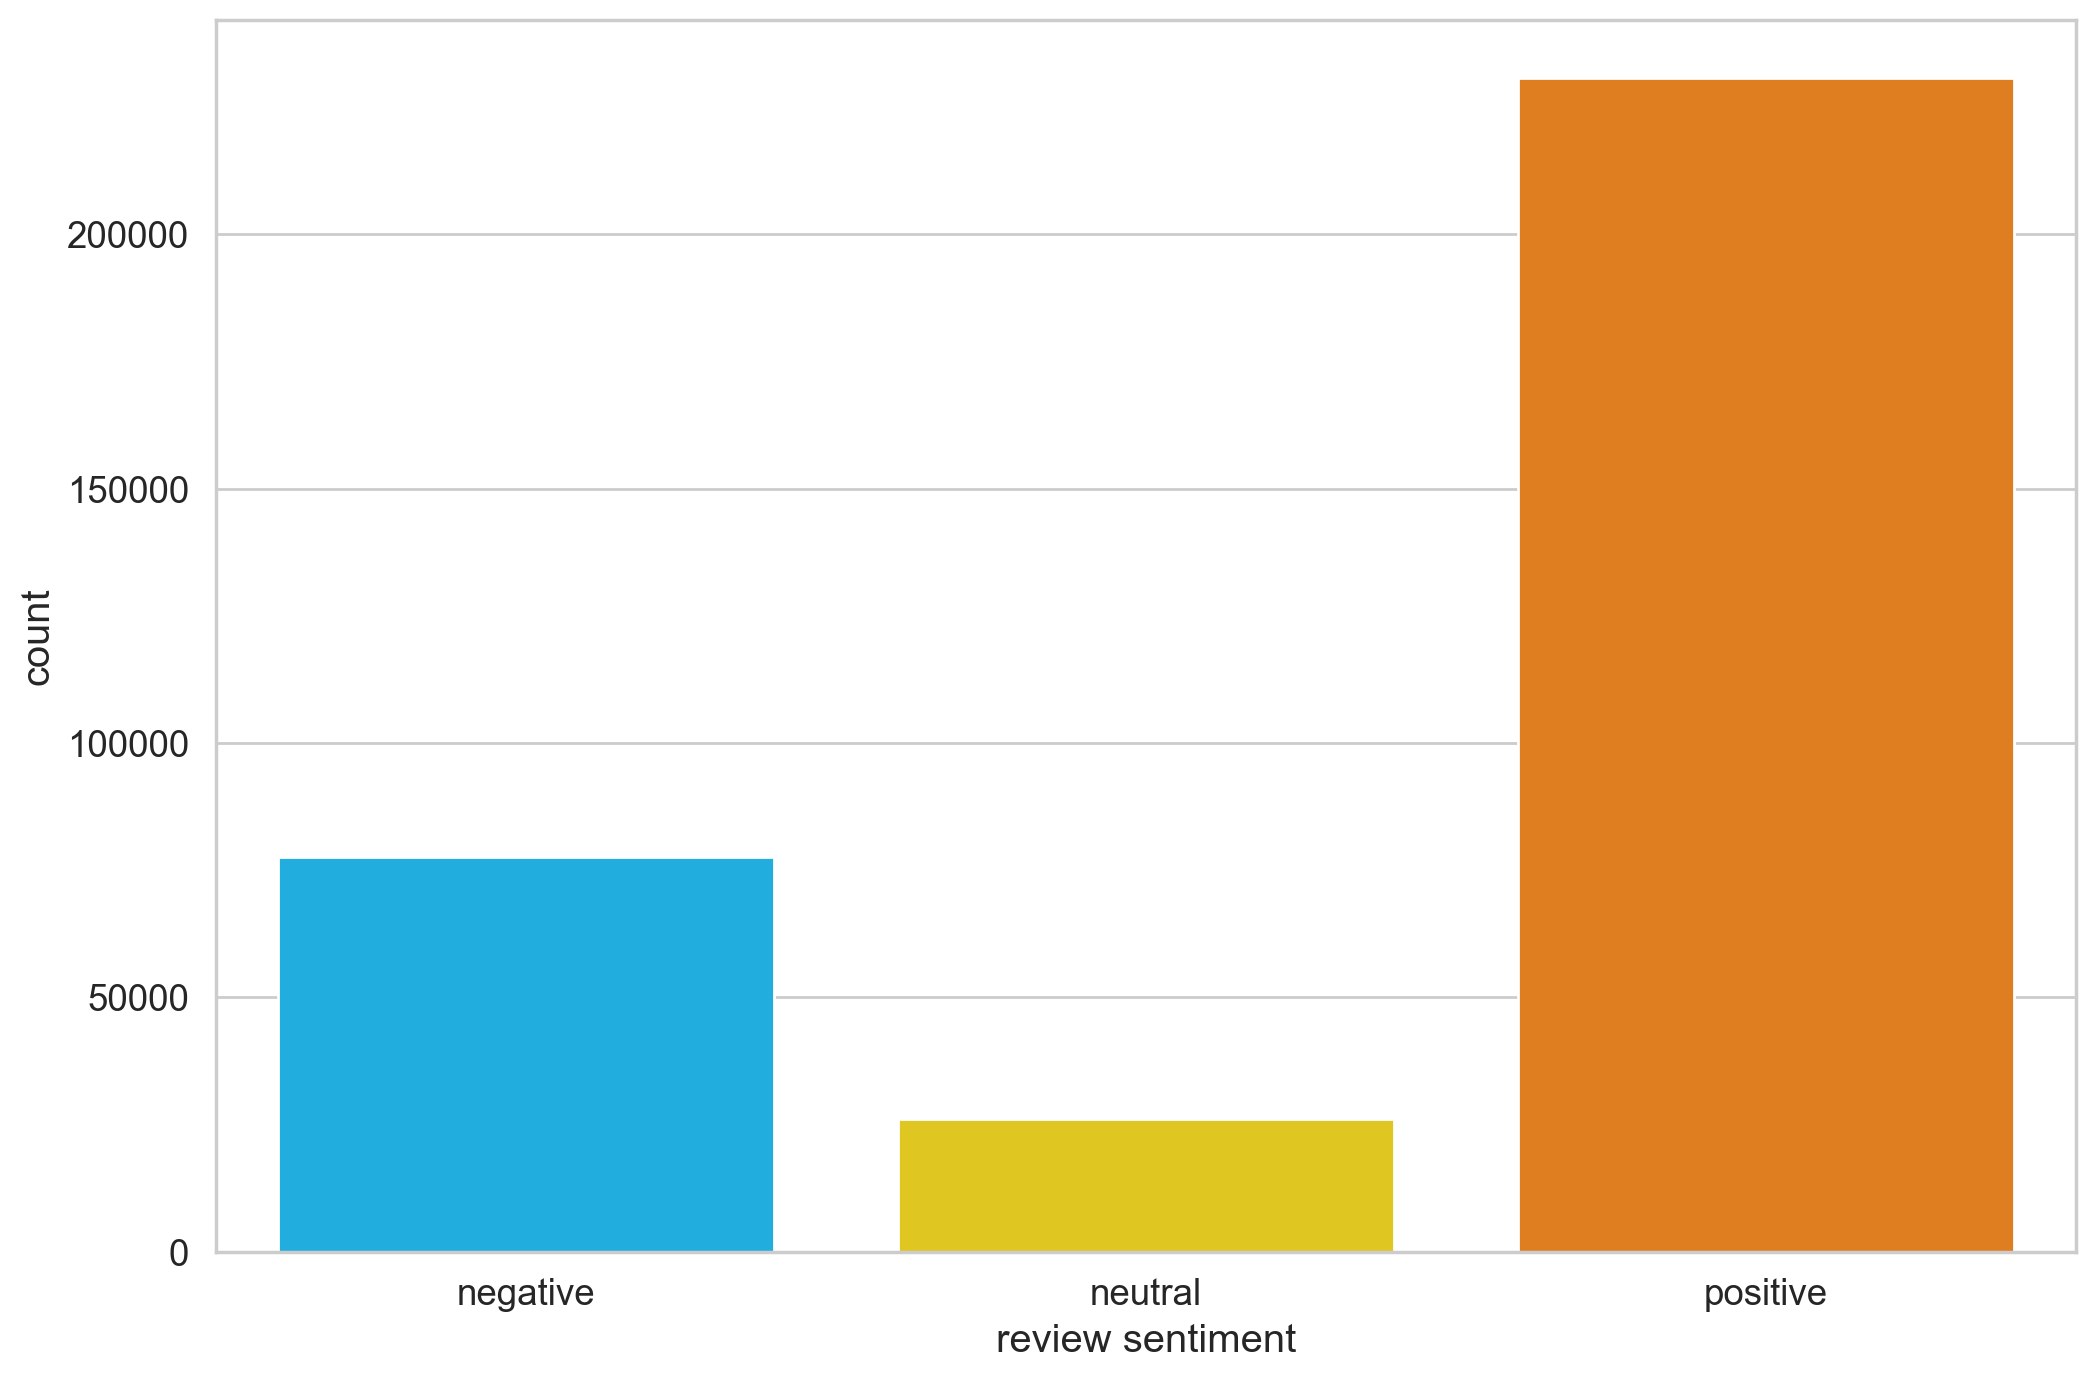

In [32]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

# Word Cloud Positive, Negative and Neutral Sentiments

In [33]:
# Sample data
data_positive = " ".join(df[df['Sentiment'] == 'positive']['Reviews'])
data_negative = " ".join(df[df['Sentiment'] == 'negative']['Reviews'])
data_neutral = " ".join(df[df['Sentiment'] == 'neutral']['Reviews'])


In [34]:
# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='black').generate(data_positive)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(data_negative)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='black').generate(data_neutral)


(-0.5, 799.5, 399.5, -0.5)

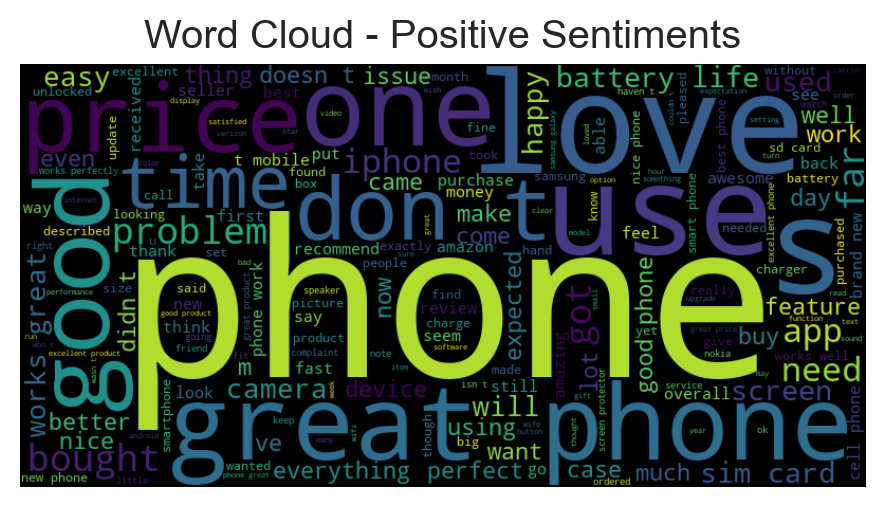

In [35]:
# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiments')
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

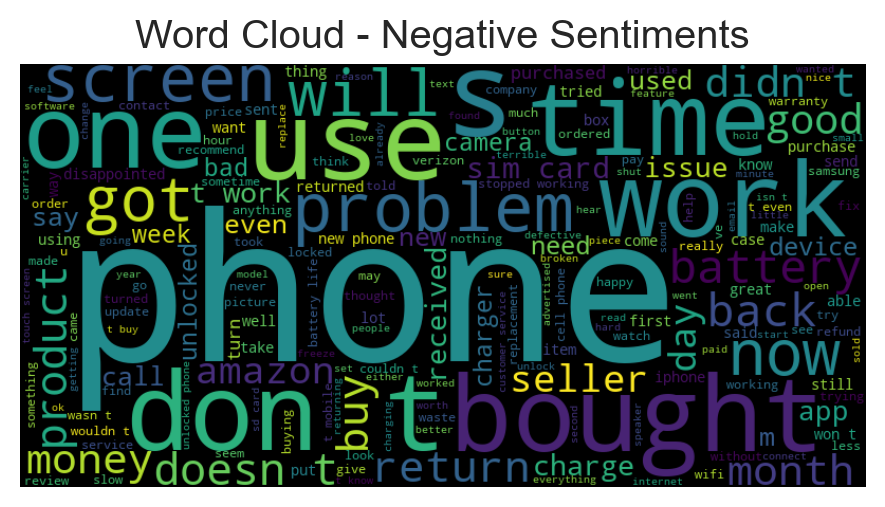

In [36]:
# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiments')
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

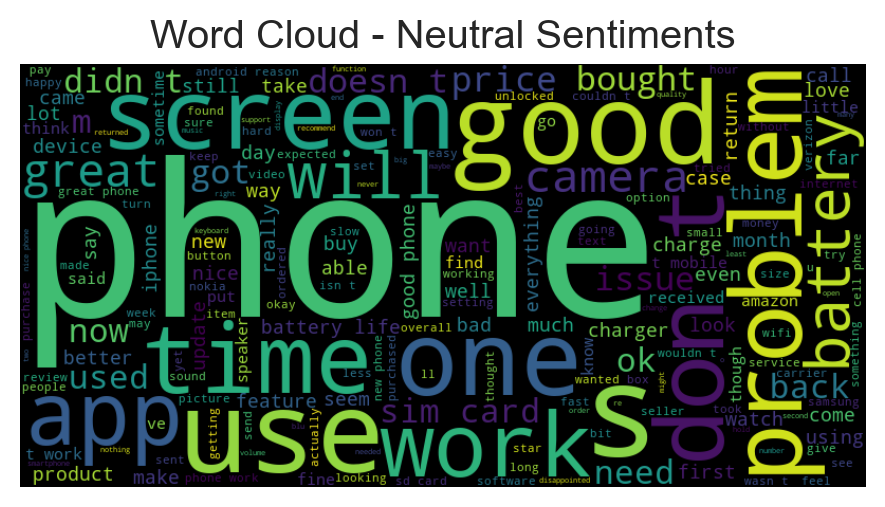

In [37]:
# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud - Neutral Sentiments')
plt.axis('off')

# Logistic Regression Classifier

In [38]:
X = df['Reviews']
y = df['Sentiment']

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Train Word2Vec model on your text data
tokenized_reviews = X_train.apply(lambda x: x.split())
# Train Word2Vec model on your text data
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)


In [41]:
# Function to generate sentence vectors using Word2Vec embeddings
def get_sentence_vector(tokens, word2vec_model, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += word2vec_model.wv[word].reshape((1, size))
            count += 1
        except KeyError:  # Ignore if word is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [42]:
# Convert training data to sentence vectors
X_train_vec = np.concatenate([get_sentence_vector(tokens, word2vec_model, 100) for tokens in tokenized_reviews])

In [43]:
# Train Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [44]:
# Convert testing data to sentence vectors
tokenized_test_reviews = X_test.apply(lambda x: x.split())
X_test_vec = np.concatenate([get_sentence_vector(tokens, word2vec_model, 100) for tokens in tokenized_test_reviews])

In [45]:
# Predictions
y_pred = lr_classifier.predict(X_test_vec)

In [46]:
# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.77      0.79      0.78     15609
     neutral       0.35      0.04      0.07      5228
    positive       0.88      0.96      0.91     46030

    accuracy                           0.85     66867
   macro avg       0.66      0.59      0.59     66867
weighted avg       0.81      0.85      0.82     66867



# Random Forest Classifier

In [47]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

In [48]:
# Predictions
y_pred = rf_classifier.predict(X_test_vec)

In [49]:
# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.92      0.91     15609
     neutral       0.97      0.63      0.77      5228
    positive       0.95      0.98      0.96     46030

    accuracy                           0.94     66867
   macro avg       0.94      0.84      0.88     66867
weighted avg       0.94      0.94      0.94     66867



# Gradient Boosting Classifier

In [51]:
# # Initialize and train the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train_vec, y_train)

GradientBoostingClassifier(random_state=42)

In [53]:
# Predict on the testing set
y_pred = gbm.predict(X_test_vec)

In [54]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8406089700450148


In [55]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.78      0.76     15609
     neutral       0.44      0.04      0.07      5228
    positive       0.87      0.95      0.91     46030

    accuracy                           0.84     66867
   macro avg       0.69      0.59      0.58     66867
weighted avg       0.81      0.84      0.81     66867



# GBM Model Saved

In [57]:
# Save the trained model to a file
joblib.dump(gbm, 'gbm_model.pkl')

# Later, you can load the trained model from the file
loaded_model = joblib.load('gbm_model.pkl')